# A Better 🐍 PyTree 🌲 interface!

So ✨ `Equinox` ✨ is an awesome package that gives us the ability to build object-oriented software in `Jax` 🤯, however it is a low-level package, designed around generality and flexibilty, which can make building a simple API for user-facing software a challenege. The less that astronomers have to learn about 😱 `lambda` functions 😱, the better! To help with this, I've constructed a class with PyTree helper methods, designed to give a simpler and more intuitive interface.

There is also a class designed to simplify interfacing with some of the most valueable packages used in conjunction with our software, namely `Optax` and `Numpyro` 😎.

If you are new to `Jax`, note that all object are *immutable*, which simply means that you can NOT do in-place updates. ie any time we update some parameter, we return a new version of that object, this will become clear throughout the tutorial!


---
## What is a PyTree? 

PyTrees are the base object that Jax works with under the hood. Fundamentally they are any series of nested lists, tuples and dictionaries (https://jax.readthedocs.io/en/latest/pytrees.html). Equinox simply allows us to extend this definition to classes, hence object-oriented Jax! All classes in ∂Lux are PyTrees at the base level. Because of these arbitrary structures, indexing and setting new values 'leaves' can be difficult, since each 'leaf' must be referred to via some 'path'. 

In [1]:
import jax
import jax.numpy as np
import matplotlib.pyplot as plt
from dLux.base import Base, ExtendedBase
%matplotlib inline

dLux warning: Jax is running in 32-bit, to enable 64-bit visit:
https://jax.readthedocs.io/en/latest/notebooks/Common_Gotchas_in_JAX.html#double-64bit-precision


## Examples

Lets create an example class that inherits from the `Base` class, which contains much of the low-level functionality. For this we will have some nested classes with various parameters. Lets instantiate these and have a look

In [2]:
# Example class
class Variances(Base):
    var_x: float
    var_y: float
    some_list: list
    some_dict: dict

    def __init__(self, var_x, var_y, some_list, some_dict):
        self.var_x = var_x
        self.var_y = var_y
        self.some_list = some_list
        self.some_dict = some_dict

# Example class
class SuperGaussian(Base):
    variances: object
    power: float

    def __init__(self, variances, power):
        self.variances = variances
        self.power = power
        
# Create an instance of the SuperGaussian object
var_x, var_y = 10, 10
power = 1
some_list = [-1, -2]
some_dict = {'a': 'foo', 'b': 'bar'}

# Create the object
variances = Variances(var_x, var_y, some_list, some_dict)
pytree = SuperGaussian(variances, 1)

# Examine the object
print(pytree)

SuperGaussian(
  variances=Variances(
    var_x=10,
    var_y=10,
    some_list=[-1, -2],
    some_dict={'a': 'foo', 'b': 'bar'}
  ),
  power=1
)


Nice! Here we have a nested structure, so to look at some of these class methods, we first need to understand the 'path' object.

## The `path` object

A `path` is simply a string that refers to some place in a pytree, with nested structures connected with dots '.', similar to accessing class attributes. Some example paths for our example pytree would look like this:

 - 'variances.var_x'
 - 'power'
 - 'variances.some_list.0'
 - 'variances.some_dict.a'
 - 'variances.some_dict'

Each of these path objects refer to some place in the pytree, not neccesarily a leaf.

---
## New Methods

We have built a series of method to operate on the parts of the pytree that these paths refer to, matching the jax.numpy.at[] method:

 - `.get()`
 - `.set()`
 - `.add()`
 - `.multiply()`
 - `.divide()`
 - `.power()`
 - `.min()`
 - `.max()`
 - `.apply()`
 - `.apply_args()`

These all have the same syntax, so lets take a look at the `.get()`, `.set()` and `.add()` methods

---


### `.get(path)`

This method simply takes in a path and returns the leaf or subtree sepcified by the path. We can also pass in a list of multiple paths, and we will get back a list of all of all of those leaves.

In [3]:
path1 = 'variances.var_x'
path2 = 'variances.some_list.0'
path3 = 'variances.some_dict'

# Get individual items
print(pytree.get(path1))
print(pytree.get(path2))
print(pytree.get(path3))

# Get list of items
print(pytree.get([path1, path2, path3]))

10
-1
{'a': 'foo', 'b': 'bar'}
[10, -1, {'a': 'foo', 'b': 'bar'}]


---
### `.set(path, value)`

This method takes in a path and a value and returns a pytree with the leaf or subtree sepcified by the path replaced with value. Similarly we can pass in a list of multiple paths and values and all of the parameters will be updated!

In [4]:
value1 = 100
value2 = -100
value3 = {'a': 'FOO', 'b': 'BAR'}

print(pytree.set([path1, path2, path3], [value1, value2, value3]))

SuperGaussian(
  variances=Variances(
    var_x=100,
    var_y=10,
    some_list=[-100, -2],
    some_dict={'a': 'FOO', 'b': 'BAR'}
  ),
  power=1
)


In [5]:
# Assign all paths to zero
print(pytree.set([path1, path2, path3], 0))

# Assign nested paths
print(pytree.set([path1, [path2, path3]], [0, 100]))

SuperGaussian(
  variances=Variances(var_x=0, var_y=10, some_list=[0, -2], some_dict=0),
  power=1
)
SuperGaussian(
  variances=Variances(var_x=0, var_y=10, some_list=[100, -2], some_dict=100),
  power=1
)


So you might notice that 'some_dict', which should presumably be a dictionary, is no-longer a dictionary! This is becuase these methods do *not* do any type checking at all! If you pass in a wrong data-type, then it will be assigned at to the leaf. This is an important caveat to be aware of, as if you accidentally put a list, or a jax array with incorrect dimensionality then later behaviour of the objects can not be guaranteed!

---
### `.add(path, value)`

As descibed, this works in the same manner to the `.set()` method, except it adds to the leaf specified by the path!

In [6]:
# Add different values
print(pytree.add([path1, path2], [1e3, -1e3]))

# Add the same value
print(pytree.add([path1, path2], 1e3))

SuperGaussian(
  variances=Variances(
    var_x=1010.0,
    var_y=10,
    some_list=[-1001.0, -2],
    some_dict={'a': 'foo', 'b': 'bar'}
  ),
  power=1
)
SuperGaussian(
  variances=Variances(
    var_x=1010.0,
    var_y=10,
    some_list=[999.0, -2],
    some_dict={'a': 'foo', 'b': 'bar'}
  ),
  power=1
)


---
### The path map (pmap)

For more complex pytree structures with many nested classes, the absolute paths to any leaf can be quite long. To help make working with these types of objeccts simpler, we can create a 'path map', which is a dictionary of the paths. Lets see how it works

In [7]:
# Define pmap
pmap = {
    'vx'   : 'variances.var_x',
    'val0' : 'variances.some_list.0',
    'val1' : 'variances.some_dict'
}

# Get items
print(pytree.get(['vx', 'val0', 'val1'], pmap=pmap))

[10, -1, {'a': 'foo', 'b': 'bar'}]


---
---

## `ExtendedBase` Extending the functionality

Part of the benefit of using Jax and Equinox is the ability to use a lot a powerful optimisation and inference tools! Using these tools can sometimes be difficult, so we have also built an extended base class that is designed to simplify interfacing with `optax` and `numpyro`.

There are four extra functions added

Equinox Functions
 > `.get_args(paths)`

Optax Functions
 > `.get_param_spec(paths, groups)`
 >
 > `.get_optimiser(paths, optimisers)`

Numpyro Functions
 > `.update_and_model(model_fn, paths, values)`

---

To get started, lets extend the functionality of the classes we were playing with earlier, adding a `.model()` method so we have something to optimise through!

In [8]:
from dLux.base import ExtendedBase
from tqdm.notebook import tqdm
import equinox as eqx
import optax

In [9]:
class SuperGaussian(ExtendedBase):
    variances: object
    power: dict

    def __init__(self, variances, power):
        self.variances = variances
        self.power = power

    def model(self, flatten=False):
        xs = np.linspace(-50, 50, 100)
        XX, YY = np.meshgrid(xs, xs)

        x = (XX / self.variances.var_x) ** 2
        y = (YY / self.variances.var_y) ** 2
        g = np.exp(-((x + y) ** self.power))

        if flatten:
            return g.flatten()
        else:
            return g

In [10]:
# Create an instance of the SuperGaussian object
var_x, var_y = 10, 10
power = 1
some_list = [-1, -2]
some_dict = {'a': 'foo', 'b': 'bar'}

# Create the object
variances = Variances(var_x, var_y, some_list, some_dict)
pytree = SuperGaussian(variances, 1)

# Examine the output gaussian
data = pytree.model()

Now lets update the values of the variances and power, so that we can try and recover them. Lets also view the inital residual.

In [11]:
# Define paths to the variables we care about, and new values
xvar, yvar, power = 'variances.var_x', 'variances.var_y', 'power'
paths = [xvar, yvar, power]
initial_values = [np.array(15.0), np.array(5.0), np.array(1.5)]

# Get a new pytree to optimise
model = pytree.set(paths, initial_values)

# Create gaussian
gauss = model.model()

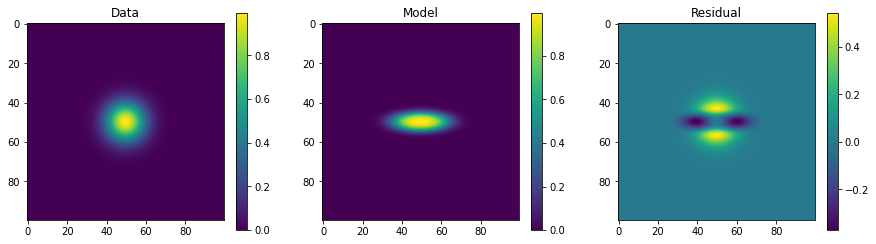

In [12]:
plt.figure(figsize=(15, 4))
plt.subplot(1, 3, 1)
plt.title("Data")
plt.imshow(data)
plt.colorbar()

plt.subplot(1, 3, 2)
plt.title("Model")
plt.imshow(gauss)
plt.colorbar()

plt.subplot(1, 3, 3)
plt.title("Residual")
plt.imshow(data - gauss)
plt.colorbar()
plt.show()

Now we want to optimise this model to recover the initial parameters. To do that we need to define a loss function, which we will use a simple least squares. Now, how do say we *only* want to optimise the variances and power values within our pytree? The `.get_args()` method! 

What does it do? This method creates an identical pytree with boolean values at the leaves of the pytree. By feeding it paths we are specifying that the leaves at those paths are replaced with `True`, which is used to specify that we want to take gradients with respect to those parameters, by passing it to the `equinox.filter_grad()` method. We also apply jit to the loss functions so it runs fast!

In [13]:
# Generate the 'args' to pass to equinox filter functions
args = model.get_args(paths)
print(args)

# Define the loss function
@eqx.filter_jit()
@eqx.filter_grad(arg=args)
def loss_fn(model, data):
    return np.sum((model.model() - data) ** 2)

SuperGaussian(
  variances=Variances(
    var_x=True,
    var_y=True,
    some_list=[False, False],
    some_dict={'a': False, 'b': False}
  ),
  power=True
)


Now we define a simple step function function so we can do gradient descent! Don't worry about the step function if you aren't sure what going on, in most cases we will use optax to do this for us

In [14]:
# Define a basic step function
step = lambda grads, lr: jax.tree_map(lambda leaf: -lr * leaf, grads)

# Optimise the model
for i in tqdm(range(500)):
    grads = loss_fn(model, data)
    model = eqx.apply_updates(model, step(grads, 1e-2))

# Print the paths to look at recovery
model.get(paths)

  0%|          | 0/500 [00:00<?, ?it/s]

[DeviceArray(10.002723, dtype=float32, weak_type=True),
 DeviceArray(9.997313, dtype=float32, weak_type=True),
 DeviceArray(1.0000018, dtype=float32, weak_type=True)]

Awesome! As we can see we were able to recover the true parameters!

---

### Optax!

<!-- So there are two methods introduced here, `.get_param_spec(paths, groups)` and `.get_optimiser(paths, optimisers)`
 -->

So here we introduce the `.get_optimiser(paths, optimisers)` method. This allows us to apply multiple different optimisation algorithms and different learning rates to different leaves! We won't go over how optax works, just how this interface works!

In [15]:
# Get a new pytree to update
model = pytree.set(paths, initial_values)

# Define paths and corresponsing optimisers using nesting
opt_paths = [[xvar, yvar], power]
optimisers = [optax.adam(1e-1), optax.adam(1e-2)]

# Get optimiser and optimisation state
optim, opt_state = model.get_optimiser(opt_paths, optimisers)

# Optimise!
for i in tqdm(range(100)):
    grads = loss_fn(model, data)
    updates, opt_state = optim.update(grads, opt_state)
    model = eqx.apply_updates(model, updates)

# Print the final values to check that eveything works
model.get(paths)

  0%|          | 0/100 [00:00<?, ?it/s]

[DeviceArray(9.98567, dtype=float32),
 DeviceArray(9.955453, dtype=float32),
 DeviceArray(0.98905396, dtype=float32)]

How easy was that!

---

### Numpyro interface!

The last package we want to be able to interact with easily is Numpyro, so we can run MCMCs!

> .update_and_model(model_fn, paths, values, *args, **kwargs)

So for this method the paths, values and path_dict should all be familiar by now. The difference here is that we also must specify with function is the one used th generate our model. This is done using a string to reference the method. Similarly if we need to pass extra agruments into the modelling function we can do that with **kwargs.

For those who haven't used Numpyro, you need to define a modelling function with all of the parameters you wish to sample. This minimal example should give you a good idea of what to do, but for a more in-depth exploration of its functionality and behaviour, check out [this great tutorial](https://dfm.io/posts/intro-to-numpyro/)

In [16]:
import numpyro as npy
import numpyro.distributions as dist
import jax.random as jr
import chainconsumer as cc

In [17]:
def modelling_fn(data, model, path_dict=None):
    """ """
    # Define parameter sampling
    var_x = npy.sample("x variance", dist.Uniform(0, 100))
    var_y = npy.sample("y variance", dist.Uniform(0, 100))
    pow   = npy.sample("power",      dist.Uniform(0, 10))

    # Define paths and values
    paths = [xvar, yvar, power]
    values = [var_x, var_y, pow]

    with npy.plate("data", len(data)):
        poisson_model = dist.Normal(
            model.update_and_model("model", paths, values, flatten=True))
        return npy.sample("super-gaussian", poisson_model, obs=data)

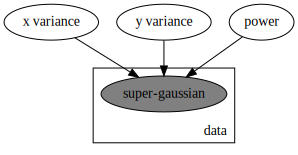

In [18]:
# # This has not yet been correctly configured for the mkdocs framework
# npy.render_model(modelling_fn, model_args=(data.flatten(), model))

In [19]:
# Using the model above, we can now sample from the posterior distribution
# using the No U-Turn Sampler (NUTS).
sampler = npy.infer.MCMC(
    npy.infer.NUTS(modelling_fn),
    num_warmup=2000,
    num_samples=2000,
    progress_bar=True,
)
%time sampler.run(jr.PRNGKey(0), data.flatten(), model)

sample: 100%|███████████████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:05<00:00, 678.17it/s, 3 steps of size 7.18e-01. acc. prob=0.90]


CPU times: user 6.87 s, sys: 61.9 ms, total: 6.93 s
Wall time: 6.91 s


In [20]:
sampler.print_summary()
values_out = sampler.get_samples()


                  mean       std    median      5.0%     95.0%     n_eff     r_hat
       power      1.07      0.21      1.05      0.72      1.37   1337.41      1.00
  x variance     10.02      1.02      9.99      8.59     11.92   1442.33      1.00
  y variance     10.05      1.02     10.05      8.44     11.73   1624.36      1.00

Number of divergences: 0


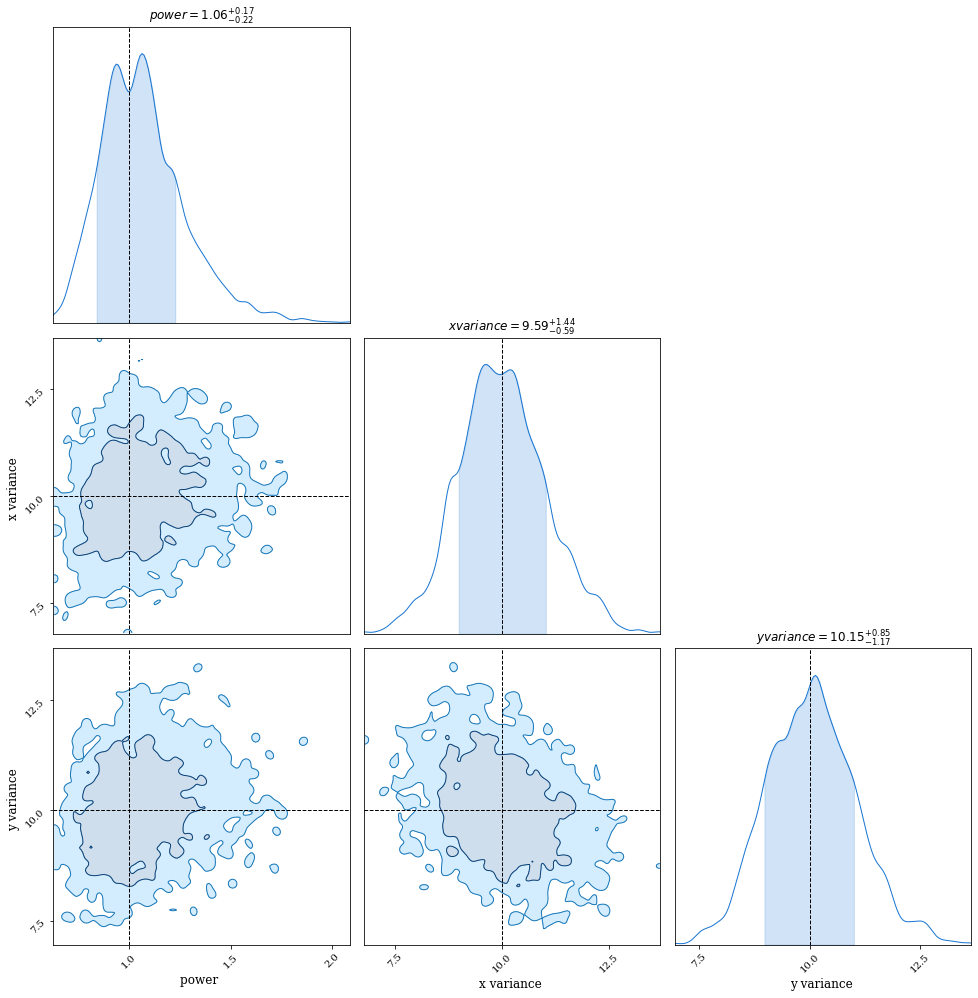

In [21]:
chain = cc.ChainConsumer()
chain.add_chain(values_out)
chain.configure(
    serif=True, shade=True, bar_shade=True, shade_alpha=0.2, spacing=1.0, max_ticks=3
)
fig = chain.plotter.plot(truth={"power": 1, "x variance": 10, "y variance": 10})
fig.set_size_inches((15, 15));